In [2]:
%load_ext autoreload
%autoreload 2

# Standard imports
import sys
sys.path.append("../../")
import time
import gc

# 3rd party imports
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import nibabel as nib
import numpy as np 
import scipy 
import SimpleITK as sitk
from tqdm import tqdm 

# Our libraries
import laplacian 
import correspondences
import jacobian

## Jacobian functions

In [3]:
def test_det(up_coord, bottom_coord, left_coord, right_coord, debug=False):
    """
    Compute the Jacobian determinant at a specific point in the deformation field.
    
    Parameters:
    - deformation: The deformation field (3D vector field).
    - coord: The coordinates of the point (z, y, x).
    
    Returns:
    - det: The Jacobian determinant at the specified point.
    """
    #print(coord)
    
    # Compute the partial derivatives
    dFx_dx = (right_coord[0] - left_coord[0]) / 2
    dFx_dy = (up_coord[0] - bottom_coord[0]) / 2
    #print(dFx_dx, dFx_dy, dFx_dz)
    #print(deformation[2, z, y, x + 1], "-", deformation[2, z, y, x - 1])

    dFy_dx = (right_coord[1] - left_coord[1]) / 2
    dFy_dy = (up_coord[1] - bottom_coord[1]) / 2

    # Form the Jacobian matrix
    # Note that the determinant of a zero vector field is also zero, whereas the Jacobian determinant of the corresponding identity warp transformation is 1.0. 
    # In order to compute the effective deformation Jacobian determinant 1.0 must be added to the diagonal elements of Jacobian prior to taking the derivative. 
    # i.e. det([ (1.0+dx/dx) dx/dy dx/dz ; dy/dx (1.0+dy/dy) dy/dz; dz/dx dz/dy (1.0+dz/dz) ])
    jacobian_matrix = np.array([
        [dFx_dx + 1, dFx_dy],
        [dFy_dx, dFy_dy + 1]
    ])
    
    if debug:
        print("(dFx/dx + 1) * (dFy/dy + 1) - (dFx/dy) * (dFy/dx)")
        print("\t" + str(dFx_dx + 1) + " * " + str(dFy_dy + 1) + " - " + str(dFx_dy) + " * " + str(dFy_dx))
        print("\t" + str((dFx_dx + 1) * (dFy_dy + 1)) + " - " + str(dFx_dy * dFy_dx))
        print("\t" + str((dFx_dx + 1) * (dFy_dy + 1) - dFx_dy * dFy_dx))
        print("Jacobian")
        print(jacobian_matrix)

    # Compute the determinant of the Jacobian matrix
    det = np.linalg.det(jacobian_matrix)

    return det

up_vec = np.array([1, 2])
bottom_vec = np.array([2, 6])
left_vec = np.array([-6, 1])
right_vec = np.array([4, 3])
print(test_det(up_vec, bottom_vec, left_vec, right_vec, debug=True))

(dFx/dx + 1) * (dFy/dy + 1) - (dFx/dy) * (dFy/dx)
	6.0 * -1.0 - -0.5 * 1.0
	-6.0 - -0.5
	-5.5
Jacobian
[[ 6.  -0.5]
 [ 1.  -1. ]]
-5.499999999999999


## Test with full points

In [4]:
def createA(fixedImage, mpoints, fpoints):
    """
    Assumes both the images are matched slice to slice according to sliceMatchList along axis- 'axis'
    Gets 2D correspondences between the slices and interpolates them smoothly across the volume
    """
    
    nx, ny, nz  = fixedImage.shape
    nd  = len(fixedImage.shape)
    print("fdata.shape", fixedImage.shape)
    
    deformationField = np.zeros((nd, nx, ny, nz))
    
    flen  = nx*ny*nz
    Xcount = np.zeros(flen)
    Ycount = np.zeros(flen)
    Zcount = np.zeros(flen)

    Xd =  np.zeros(flen)
    Yd =  np.zeros(flen)
    Zd =  np.zeros(flen)

    fIndices = fpoints[:,0] * ny*nz + fpoints[:,1] * nz + fpoints[:,2]
    fIndices = fIndices.astype(int)
    
    Xcount[fIndices] +=1 # Added (AT)
    Ycount[fIndices] +=1
    Zcount[fIndices] +=1
    Xd[fIndices] += mpoints[:,0] - fpoints[:,0]  # Added (AT)
    Yd[fIndices] += mpoints[:,1] - fpoints[:,1]
    Zd[fIndices] += mpoints[:,2] - fpoints[:,2]
    
    start = time.time()
    A = laplacian.laplacianA3D(fixedImage.shape, Ycount.nonzero()[0])
    end = time.time()
    print("Time taken to create A: ", end-start)
    return A


def createA_no_correspondences(fixedImage, mpoints, fpoints):
    """
    Assumes both the images are matched slice to slice according to sliceMatchList along axis- 'axis'
    Gets 2D correspondences between the slices and interpolates them smoothly across the volume
    """
    
    nx, ny, nz  = fixedImage.shape
    nd  = len(fixedImage.shape)
    print("fdata.shape", fixedImage.shape)
    
    deformationField = np.zeros((nd, nx, ny, nz))
    
    flen  = nx*ny*nz
    Xcount = np.zeros(flen)
    Ycount = np.zeros(flen)
    Zcount = np.zeros(flen)

    Xd =  np.zeros(flen)
    Yd =  np.zeros(flen)
    Zd =  np.zeros(flen)

    fIndices = fpoints[:,0] * ny*nz + fpoints[:,1] * nz + fpoints[:,2]
    fIndices = fIndices.astype(int)
    
    Xcount[fIndices] +=1 # Added (AT)
    Ycount[fIndices] +=1
    Zcount[fIndices] +=1
    Xd[fIndices] += mpoints[:,0] - fpoints[:,0]  # Added (AT)
    Yd[fIndices] += mpoints[:,1] - fpoints[:,1]
    Zd[fIndices] += mpoints[:,2] - fpoints[:,2]
    
    start = time.time()
    A = laplacianA3D_no_correspondences(fixedImage.shape, Ycount.nonzero()[0])
    end = time.time()
    print("Time taken to create A: ", end-start)
    return A


def laplacianA3D_no_correspondences(shape, boundaryIndices):
    """
    Creates the matrix A that correspond to the linear system of ewuations used to perform laplacian Interpolation on 3D volume images

    Parameters
    --------------
    shape : tuple 3D shape
    boundaryIndices : indices of boundary points when flattened. If (x,y) is pixel x*shape[1]*shape[2]+y*shape[2]+z will be flattened index. 
    """
    k = len(shape)
    # Create X,Y,Z arrays that represent the x,y,z indices of each voxel
    X,Y,Z = np.meshgrid(range(shape[0]), range(shape[1]), range(shape[2]), indexing='ij')

    X=X.flatten().astype(int)
    Y=Y.flatten().astype(int)
    Z=Z.flatten().astype(int)

    # Calculate each voxel's index when flattened
    ids_0  = X* shape[1]*shape[2] + Y*shape[2]+ Z
    data  = np.ones(len(ids_0)) * 2*k
    boundaryIndices = boundaryIndices.astype(int)
    boundaryIndices = [0]
    print("Boundary Indices")
    print(boundaryIndices)

    """
    rids: row indices value
    cids: column indices values
    data: Diagonal entries of sparse matrix A. A[rid, rid] = 6 at all non boundary locations. 
          A[rid, rid] = 1 at Dirchlet boundary. A[rid, rid] = number of valid neighbours at volume boundary


    """
    print("Building data for Laplacian Sparse Matrix A")

    # Calculate the voxel index of (x-1,y,z) for each (x,y,z)
    cids_x1  = (X-1)* shape[1]*shape[2] + Y*shape[2]+ Z
    invalid_cx1 = np.concatenate([np.where(X==0)[0], boundaryIndices])  # invalid column indices and coorespondences indices. X==0 is invalid because X-1 will be negative
    rids_x1  = np.delete(ids_0, invalid_cx1) # remove invalid row indices that correspond to column
    cids_x1  = np.delete(cids_x1, invalid_cx1) # remove invalid column indices
    print("Invalid Column Indices")
    print(invalid_cx1)
    print("rids_x1")
    print(rids_x1)
    print("cids_x1")
    print(cids_x1)
    data[invalid_cx1] -=1   # decrease the value of A[rid, rid] by 1 at invalid indices

    # Calculate the voxel index of (x+1,y,z) for each (x,y,z)
    cids_x2  = (X+1)* shape[1]*shape[2] + Y*shape[2]+ Z
    invalid_cx2 = np.concatenate([np.where(X==shape[0] -1 )[0], boundaryIndices])
    rids_x2  = np.delete(ids_0, invalid_cx2)
    cids_x2  = np.delete(cids_x2, invalid_cx2)
    data[invalid_cx2] -=1

    # Calculate the voxel index of (x,y-1,z) for each (x,y,z)
    cids_y1  = X* shape[1]*shape[2] + (Y-1)*shape[2]+ Z
    invalid_cy1 = np.concatenate([np.where(Y==0)[0], boundaryIndices])
    rids_y1  = np.delete(ids_0, invalid_cy1)
    cids_y1  = np.delete(cids_y1, invalid_cy1)
    data[invalid_cy1] -=1

    # Calculate the voxel index of (x,y+1,z) for each (x,y,z)
    cids_y2  = X* shape[1]*shape[2] + (Y+1)*shape[2]+ Z
    invalid_cy2 = np.concatenate([np.where(Y==shape[1]-1)[0], boundaryIndices])
    rids_y2  = np.delete(ids_0, invalid_cy2)
    cids_y2  = np.delete(cids_y2, invalid_cy2)
    data[invalid_cy2] -=1

    # Calculate the voxel index of (x,y,z-1) for each (x,y,z)
    cids_z1  = X* shape[1]*shape[2] + Y*shape[2]+ Z-1
    invalid_cz1 = np.concatenate([np.where(Z==0)[0], boundaryIndices])
    rids_z1  = np.delete(ids_0, invalid_cz1)
    cids_z1  = np.delete(cids_z1, invalid_cz1)
    data[invalid_cz1] -=1

    # Calculate the voxel index of (x,y,z+1) for each (x,y,z)
    cids_z2  = X* shape[1]*shape[2] +Y*shape[2]+ Z+1
    invalid_cz2 = np.concatenate([np.where(Z==shape[2] - 1)[0], boundaryIndices])   
    rids_z2  = np.delete(ids_0, invalid_cz2)  
    cids_z2  = np.delete(cids_z2, invalid_cz2) 
    data[invalid_cz2] -=1 

    # Diagonal entries corresponding to dirichlet boundaries should be 1
    #data[boundaryIndices] +=1

    rowx = np.hstack([ids_0, rids_x1, rids_x2,rids_y1,rids_y2, rids_z1, rids_z2])
    rowy = np.hstack([ids_0, cids_x1, cids_x2,cids_y1,cids_y2, cids_z1, cids_z2])
    rowv = np.hstack([data , -1*np.ones(rowx.shape[0] - ids_0.shape[0]) ] )

    print("Creating Laplacian Sparse Matrix A (no correspondences)")
    A = scipy.sparse.csr_matrix((rowv,(rowx,rowy)), shape =(X.shape[0],X.shape[0]), dtype=np.int8)
    del rowx, rowy, rowv, X, Y,Z, data
    gc.collect()

    return A


from scipy.sparse.linalg import svds

# Function to estimate the rank of a sparse matrix
def estimate_sparse_rank(A, tol=1e-10):
    # Compute the singular values
    u, s, vt = svds(A, k=min(A.shape)-1)
    
    # Count non-zero singular values greater than the tolerance
    rank = np.sum(s > tol)
    return rank

## Create downsampled set of points from original

In [5]:
mpoints_path = "data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "data/corrected_correspondences_count_touching/fpoints.npy"
template_ccf = "../../CCF_DATA/average_template_25.nii.gz"

mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)
template = np.zeros((528, 320, 456))

mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path)

## Create a Laplacian matrix

Number of correspondences: 43
Loading fixed image
Loaded fixed image
fdata.shape (3, 20, 40)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04031205177307129s
Computing dy
dy calculated in 0.043291568756103516s
Computing dx
dx calculated in 0.046427011489868164s
(3, 3, 20, 40)
Shape of A: (2400, 2400)
Rank of A: 2400
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]

Creating A2 (local function that doesn't include correspondences in matrix)
fdata.shape (3, 20, 40)
Boundary Indices
[0]
Building data for Laplacian Sparse Matrix A
Invalid Column Indices
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57 

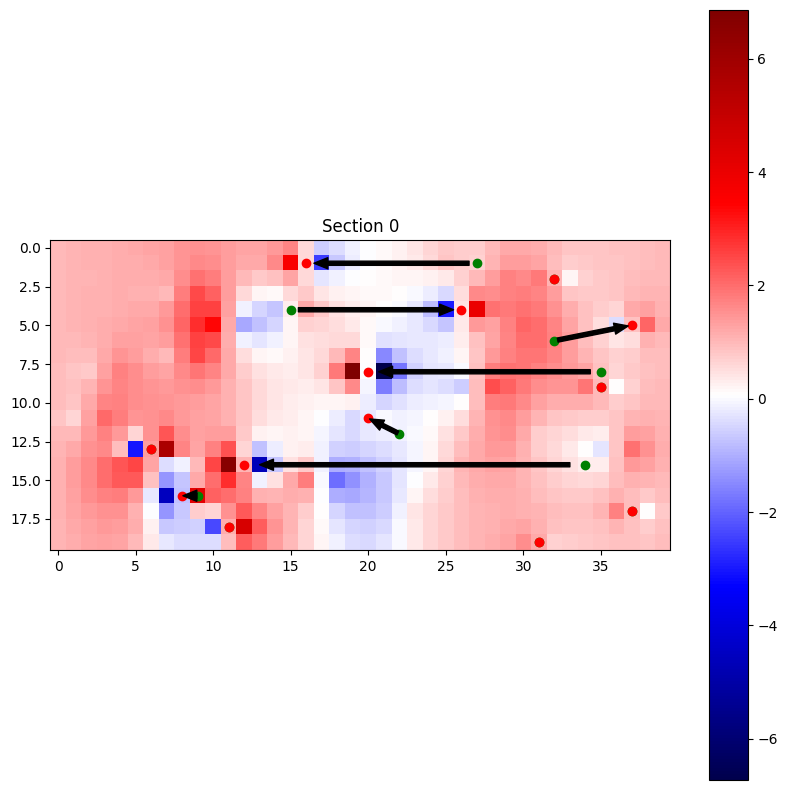

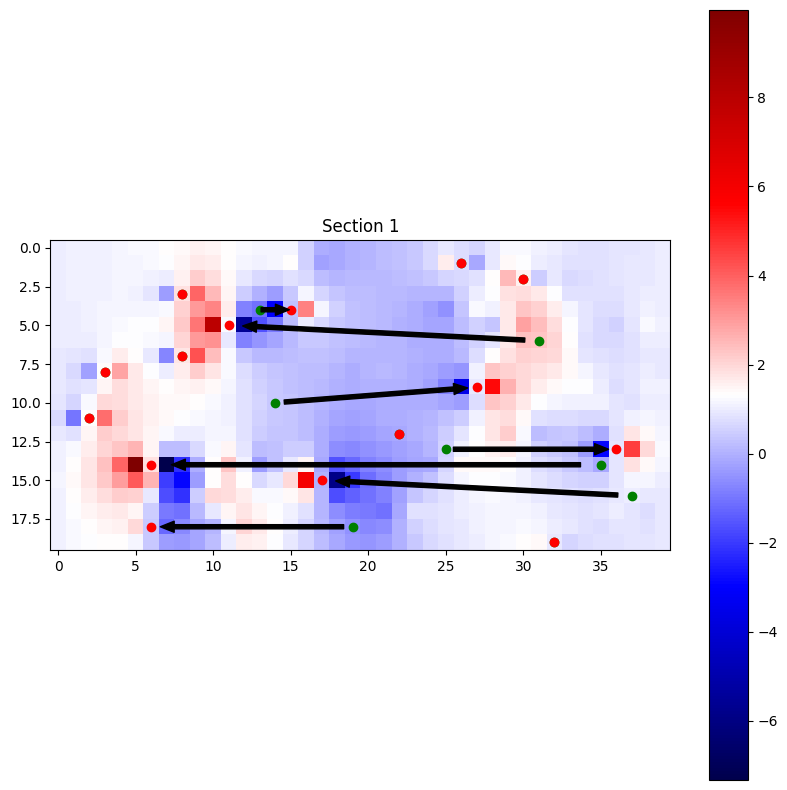

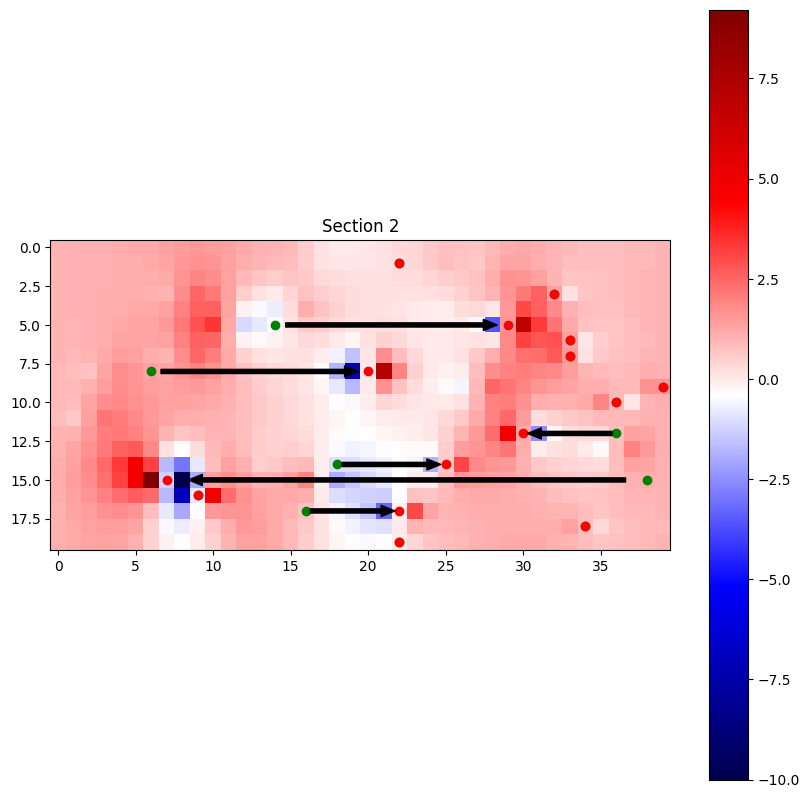

In [6]:
# Create a Laplacian matrix from the downsampled correspondence points
USE_ONE_IDX = False
# Select specific indices
if USE_ONE_IDX:
    curr_idx = 2
    curr_mpoints = mpoints[mpoints[:, 0] == curr_idx].copy()
    curr_fpoints = fpoints[fpoints[:, 0] == curr_idx].copy()
    curr_mpoints[:, 0] = 0
    curr_fpoints[:, 0] = 0
    print(curr_mpoints.shape)
    print(curr_fpoints.shape)
    fixed_sample = np.zeros((1, 20, 40))
else:
    # Use all indices
    curr_mpoints = mpoints.copy()
    curr_fpoints = fpoints.copy()
    print("Number of correspondences:", curr_mpoints.shape[0])
    fixed_sample = np.zeros((3, 20, 40))
    
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, curr_mpoints, curr_fpoints)
print(deformation.shape)
print("Shape of A:", A.shape)
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
A_dense = A.toarray()
print(A_dense)

# Make an A matrix that doesn't include correspondences
print()
print("Creating A2 (local function that doesn't include correspondences in matrix)")
A2 = createA_no_correspondences(fixed_sample, curr_mpoints, curr_fpoints)
print("Rank of A2:", np.linalg.matrix_rank(A2.toarray()))
print()

# Visualize the Jacobian determinants
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))
print("Jaocbian det shape:", jacobian_det.shape)
for i in range(jacobian_det.shape[0]):
    plt.figure(figsize=(10, 10))
    norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())
    plt.imshow(jacobian_det[i], cmap='seismic')
    plt.title("Section " + str(i))
    plt.colorbar()
    
    curr_mpoints_slice = mpoints[mpoints[:, 0] == i][:, 1:]
    curr_fpoints_slice = fpoints[fpoints[:, 0] == i][:, 1:]

    plt.scatter(curr_mpoints_slice[:, 1], curr_mpoints_slice[:, 0], c='g')
    plt.scatter(curr_fpoints_slice[:, 1], curr_fpoints_slice[:, 0], c='r')
    
    for j in range(len(curr_mpoints_slice)):
        plt.annotate(
            '', 
            xy=(curr_fpoints_slice[j][1], curr_fpoints_slice[j][0]), 
            xytext=(curr_mpoints_slice[j][1], curr_mpoints_slice[j][0]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    #for j in range(len(curr_mpoints_slice)):
    #    plt.plot([curr_mpoints_slice[j][1], curr_fpoints_slice[j][1]], 
    #             [curr_mpoints_slice[j][0], curr_fpoints_slice[j][0]], color='blue', alpha=0.75)
    
    plt.show()


Create some sample points of our own

Loading fixed image
Loaded fixed image
fdata.shape (1, 5, 5)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04293704032897949s
Computing dy
dy calculated in 0.0429837703704834s
Computing dx
dx calculated in 0.04379987716674805s
A shape: (25, 25)
A with correspondences:
[[ 2. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0

/home/andy/anaconda3/envs/tissuecyte/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


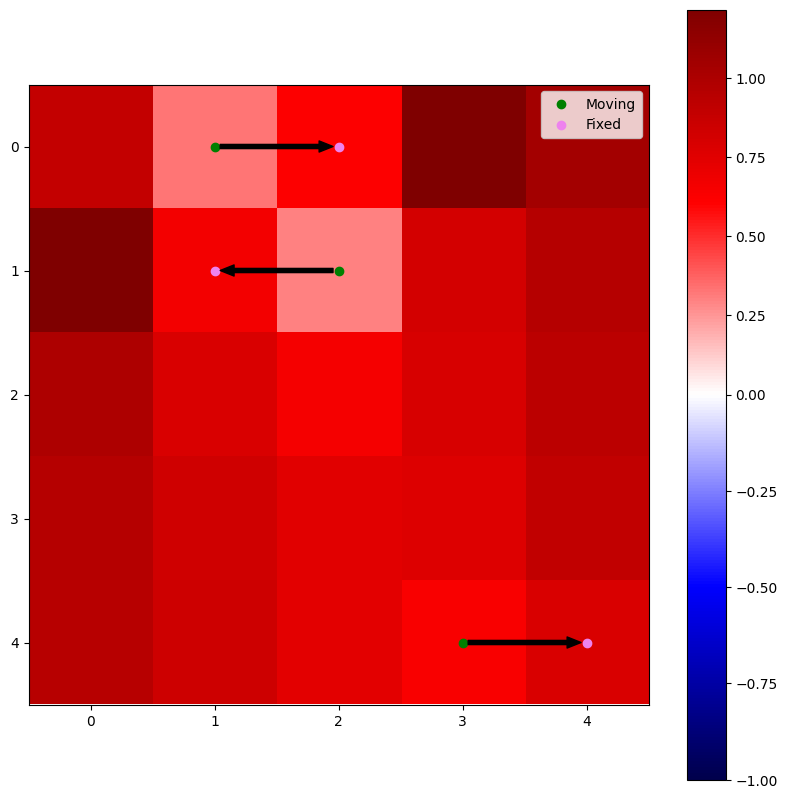

In [7]:
# Create some example correspondence points
"""
msample = np.array([
    [0, 0, 1],
    [0, 2, 0],
    [0, 3, 0],
    [0, 4, 4],
    [0, 4, 2],
    [0, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    [0, 1, 3],
    [0, 3, 1],
    [0, 4, 3],
    [0, 3, 2],
    [0, 0, 4],
])
"""

# Create some example correspondence points
msample = np.array([
    [0, 0, 1],  # T
    #[0, 2, 0],
    #[0, 3, 0],
    [0, 4, 3],  # T
    #[0, 4, 2],
    [0, 1, 2],  # T
    #[1, 0, 1],
    #[1, 2, 0],
    #[1, 3, 0],
    #[1, 4, 4],
    #[1, 4, 2],
    #[1, 0, 4],
])
fsample = np.array([
    [0, 0, 2],  # T
    #[0, 1, 3],
    #[0, 3, 1],
    [0, 4, 4],  # T
    #[0, 3, 2],
    [0, 1, 1],  # Middle T
    #[1, 0, 2],
    #[1, 2, 3],
    #[1, 3, 1],
    #[1, 4, 3],
    #[1, 3, 2],
    #[1, 0, 4],
])


"""
msample = np.array([
    [0, 0, 1],
    [0, 2, 0],
    [0, 3, 0],
    [0, 4, 4],
    [0, 4, 2],
    [0, 0, 4],
    [0, 3, 3],
])
fsample = np.array([
    [0, 0, 2],
    [0, 1, 3],
    [0, 3, 1],
    [0, 4, 3],
    [0, 3, 2],
    [0, 0, 4],
    [0, 1, 1]
])
"""

# Visualize the points
"""
plt.figure(figsize=(10, 10))
plt.scatter(msample[:, 2], msample[:, 1], c='g')
plt.scatter(fsample[:, 2], fsample[:, 1], c='r')
for i in range(len(msample)):
    plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='blue', alpha=0.75)
plt.gca().invert_yaxis()
plt.show()
"""

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((1, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
Adense = A.toarray()
print("A with correspondences:")
print(Adense)
print("Rank of A:", np.linalg.matrix_rank(Adense))
print("A[2]:", Adense[2])
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
#print("Deformation shape:", deformation.shape)
#print("Deformation:")
#print(deformation)
print()

print()
A2 = createA_no_correspondences(fixed_sample, msample, fsample)
# Set first row of A2 to A
A2[0] = A[0]
print("A2 without correspondences:")
print(A2.toarray())
print("Rank of A2:", np.linalg.matrix_rank(A2.toarray()))
print()
np.save("A2.npy", A2.toarray())

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

In [19]:
A2_dense = A2.todense()
A2_sum = np.sum(A2_dense[1:], axis=0)
print(A2_sum)
print(A2_dense[0])
-A2_sum == A2_dense[0]

[[-2  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
[[ 2 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


matrix([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [ ]:
# Create some example correspondence points
"""
msample = np.array([
    [0, 0, 1],
    [0, 2, 0],
    [0, 3, 0],
    [0, 4, 4],
    [0, 4, 2],
    [0, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    [0, 1, 3],
    [0, 3, 1],
    [0, 4, 3],
    [0, 3, 2],
    [0, 0, 4],
])
"""

# Create some example correspondence points
msample = np.array([
    [0, 0, 1],  # T
    #[0, 2, 0],
    #[0, 3, 0],
    [0, 4, 3],  # T
    #[0, 4, 2],
    [0, 1, 2],  # T
    #[1, 0, 1],
    #[1, 2, 0],
    #[1, 3, 0],
    #[1, 4, 4],
    #[1, 4, 2],
    #[1, 0, 4],
])
fsample = np.array([
    [0, 0, 2],  # T
    #[0, 1, 3],
    #[0, 3, 1],
    [0, 4, 4],  # T
    #[0, 3, 2],
    [0, 1, 1],  # Middle T
    #[1, 0, 2],
    #[1, 2, 3],
    #[1, 3, 1],
    #[1, 4, 3],
    #[1, 3, 2],
    #[1, 0, 4],
])

# Visualize the points
"""
plt.figure(figsize=(10, 10))
plt.scatter(msample[:, 2], msample[:, 1], c='g')
plt.scatter(fsample[:, 2], fsample[:, 1], c='r')
for i in range(len(msample)):
    plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='blue', alpha=0.75)
plt.gca().invert_yaxis()
plt.show()
"""

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((3, 3, 3))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
Adense = A.toarray()
print("A with correspondences:")
print(Adense)
print("Rank of A:", np.linalg.matrix_rank(Adense))
print("A[2]:", Adense[2])
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
#print("Deformation shape:", deformation.shape)
#print("Deformation:")
#print(deformation)
print()

print()
A2 = createA_no_correspondences(fixed_sample, msample, fsample)
# Set first row of A2 to A
A2[0] = A[0]
print("A2 without correspondences:")
print(A2.toarray())
print("Rank of A2:", np.linalg.matrix_rank(A2.toarray()))
print()

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()